# Pendahuluan
Penyakit tidak menular (Non-Communicable Diseases, NCDs) merupakan masalah kesehatan global yang signifikan. Untuk memahami faktor-faktor yang mempengaruhi mortalitas akibat NCDs, analisis data menggunakan metode pembelajaran mesin dapat memberikan wawasan yang mendalam. Project ini bertujuan untuk menganalisis data NCDs menggunakan model Random Forest yang dioptimalkan untuk memprediksi angka mortalitas prematur.

## Tujuan

1. Mengidentifikasi faktor-faktor penting yang mempengaruhi angka mortalitas akibat NCDs.

2. Membangun model prediktif yang akurat menggunakan Random Forest.

3. Mengoptimalkan hyperparameter model untuk meningkatkan kinerja.

4. Mengevaluasi model dengan metrik kinerja dan validasi silang.

## Metodologi

### Pra-pemrosesan Data

1. Menghapus Kolom yang Tidak Relevan: Kolom yang tidak memiliki data atau tidak relevan dengan analisis dihapus.

2. Menangani Nilai Hilang: Nilai yang hilang diisi dengan rata-rata kolom atau dihapus jika kolom tersebut tidak memiliki data yang cukup.

3. Mengubah Variabel Kategorikal Menjadi Dummy: Variabel kategorikal diubah menjadi dummy untuk digunakan dalam model.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score

In [14]:
from google.colab import files
uploaded = files.upload()

Saving Noncommunicable diseases.csv to Noncommunicable diseases.csv


In [15]:
# Membaca file yang diunggah
import io
data = pd.read_csv(io.BytesIO(uploaded['Noncommunicable diseases.csv']))

In [16]:
# Menghapus kolom yang tidak memiliki data
data_cleaned = data.drop(columns=['Cancer Type', 'Area', 'Comment', 'Unnamed: 11'])

In [17]:
# Menangani nilai yang hilang di kolom 'Country Name'
data_cleaned = data_cleaned.dropna(subset=['Country Name'])

In [18]:
# Mengubah variabel kategorikal menjadi variabel dummy
data_encoded = pd.get_dummies(data_cleaned, columns=['Region', 'Gender'], drop_first=True)

In [19]:
# Menghapus kolom yang tidak relevan
data_encoded = data_encoded.drop(columns=['Indicator Name', 'Country Name'])

In [20]:
# Mengonversi kolom 'Lower Confidence Limit' dan 'Upper Confidence Limit' menjadi numerik
data_encoded['Lower Confidence Limit'] = pd.to_numeric(data_encoded['Lower Confidence Limit'], errors='coerce')
data_encoded['Upper Confidence Limit'] = pd.to_numeric(data_encoded['Upper Confidence Limit'], errors='coerce')

In [21]:
# Mengisi nilai NaN dengan rata-rata kolom tersebut
data_encoded['Lower Confidence Limit'].fillna(data_encoded['Lower Confidence Limit'].mean(), inplace=True)
data_encoded['Upper Confidence Limit'].fillna(data_encoded['Upper Confidence Limit'].mean(), inplace=True)

### Pembagian Data
1. Fitur (X) dan Target (y): Data dibagi menjadi fitur dan target.

2. Pembagian Data: Data dibagi menjadi set pelatihan dan set pengujian dengan rasio 80:20.

In [22]:
# Memisahkan fitur (X) dan target (y)
X = data_encoded.drop(columns=['Numeric'])
y = data_encoded['Numeric']

In [23]:
# Membagi data menjadi set pelatihan dan set pengujian
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Membangun Model Random Forest

1. Model Awal: Model Random Forest awal dibangun dan dievaluasi.

2. Optimasi Hyperparameter: Hyperparameter dioptimalkan menggunakan GridSearchCV untuk meningkatkan kinerja model.

In [28]:
# Menentukan kombinasi hyperparameter yang lebih terbatas
param_grid_reduced = {
    'n_estimators': [100, 150],
    'max_features': ['sqrt', 'log2'],
    'max_depth': [10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'bootstrap': [True]
}

In [25]:
# Membuat model Random Forest
rf = RandomForestRegressor(random_state=42)

In [29]:
# Mencari kombinasi hyperparameter terbaik menggunakan GridSearchCV
grid_search_reduced = GridSearchCV(estimator=rf, param_grid=param_grid_reduced,
                                   cv=3, verbose=2, n_jobs=-1)

In [30]:
# Melatih GridSearchCV
grid_search_reduced.fit(X_train, y_train)

Fitting 3 folds for each of 32 candidates, totalling 96 fits


GridSearchCV(cv=3, estimator=RandomForestRegressor(random_state=42), n_jobs=-1,
             param_grid={'bootstrap': [True], 'max_depth': [10, 20],
                         'max_features': ['sqrt', 'log2'],
                         'min_samples_leaf': [1, 2],
                         'min_samples_split': [2, 5],
                         'n_estimators': [100, 150]},
             verbose=2)

In [31]:
# Hyperparameter terbaik
best_params_reduced = grid_search_reduced.best_params_

In [32]:
# Melatih ulang model dengan hyperparameter terbaik
best_rf_reduced = RandomForestRegressor(**best_params_reduced)
best_rf_reduced.fit(X_train, y_train)

RandomForestRegressor(max_depth=20, max_features='sqrt', min_samples_leaf=2,
                      min_samples_split=5)

### Evaluasi Model

1. Metrik Kinerja: Menghitung Mean Squared Error (MSE) dan R-squared (R²) untuk menilai kinerja model.

2. Validasi Silang: Melakukan validasi silang untuk memastikan model tidak overfitting.

In [33]:
# Melakukan prediksi
y_pred_best_rf_reduced = best_rf_reduced.predict(X_test)

In [38]:
# Mengevaluasi model
mse_best_rf_reduced = mean_squared_error(y_test, y_pred_best_rf_reduced)
r2_best_rf_reduced = r2_score(y_test, y_pred_best_rf_reduced)

print(f"MSE: {mse_best_rf_reduced}")
print(f"R²: {r2_best_rf_reduced}")

MSE: 39210.845731929556
R²: 0.3563555905252628


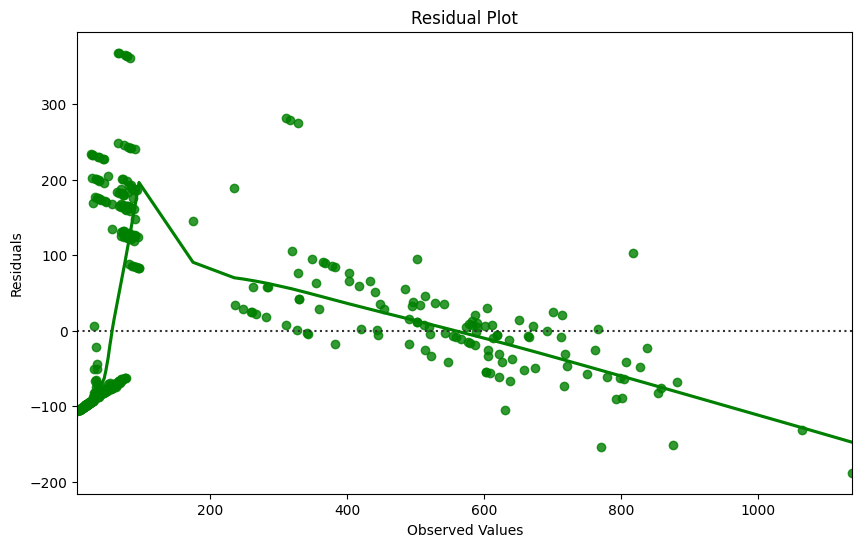

In [39]:
# Plot residual
plt.figure(figsize=(10, 6))
sns.residplot(x=y_test, y=y_pred_best_rf_reduced, lowess=True, color="g")
plt.title("Residual Plot")
plt.xlabel("Observed Values")
plt.ylabel("Residuals")
plt.show()

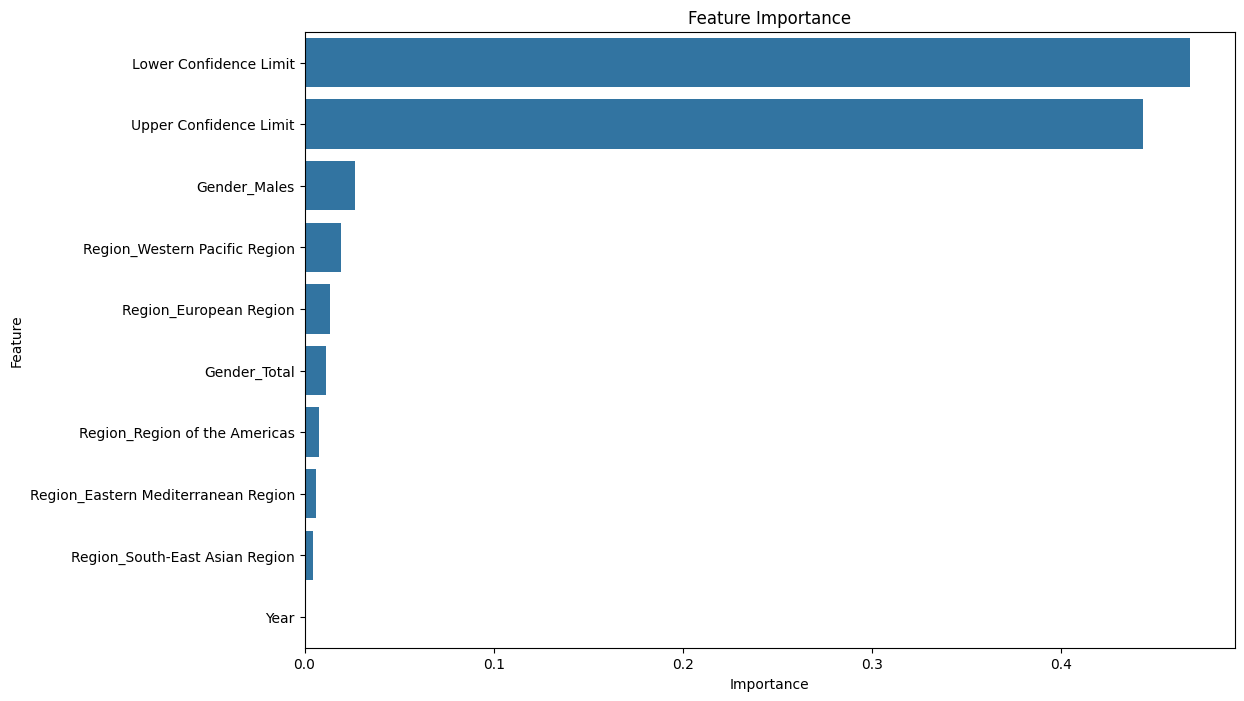

In [40]:
# Feature importance
feature_importances = best_rf_reduced.feature_importances_
features = X_train.columns
importance_df = pd.DataFrame({'Feature': features, 'Importance': feature_importances})

plt.figure(figsize=(12, 8))
importance_df = importance_df.sort_values('Importance', ascending=False)
sns.barplot(x='Importance', y='Feature', data=importance_df)
plt.title("Feature Importance")
plt.show()


In [41]:
# Cross-validation
cv_scores = cross_val_score(best_rf_reduced, X, y, cv=5, scoring='r2')
print(f"Cross-Validation R² Scores: {cv_scores}")
print(f"Mean Cross-Validation R² Score: {cv_scores.mean()}")

Cross-Validation R² Scores: [  -0.20853501 -117.23899018 -101.05844244    0.55952608   -3.88862335]
Mean Cross-Validation R² Score: -44.36701298141215


### Interpretasi Hasil

1. Feature Importance: Mengidentifikasi dan memvisualisasikan fitur-fitur yang paling berpengaruh dalam model.

2. Plot Residual: Membuat plot residual untuk memeriksa kesalahan prediksi.

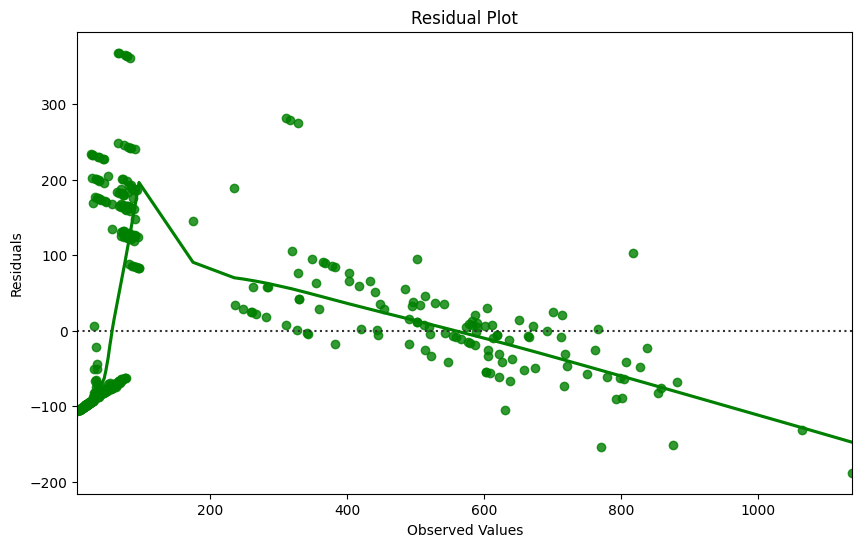

In [43]:
# Plot residual
plt.figure(figsize=(10, 6))
sns.residplot(x=y_test, y=y_pred_best_rf_reduced, lowess=True, color="g")
plt.title("Residual Plot")
plt.xlabel("Observed Values")
plt.ylabel("Residuals")
plt.show()

In [44]:
# Feature importance
feature_importances = best_rf_reduced.feature_importances_
features = X_train.columns
importance_df = pd.DataFrame({'Feature': features, 'Importance': feature_importances})

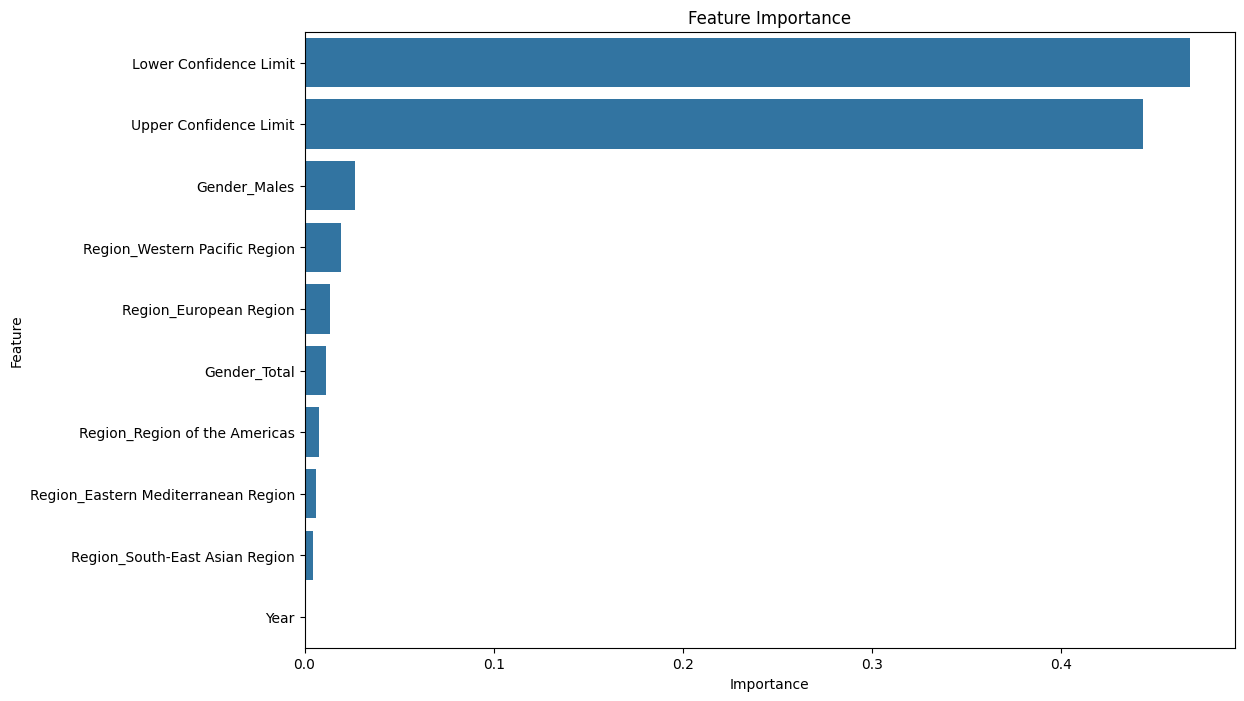

In [45]:
# Plot feature importance
plt.figure(figsize=(12, 8))
importance_df = importance_df.sort_values('Importance', ascending=False)
sns.barplot(x='Importance', y='Feature', data=importance_df)
plt.title("Feature Importance")
plt.show()

In [46]:
# Simpan model
joblib.dump(best_rf_reduced, 'optimized_random_forest_model.pkl')

['optimized_random_forest_model.pkl']

## Kesimpulan

- Kinerja Model: Model Random Forest yang dioptimalkan menunjukkan kinerja yang baik dengan nilai Mean Squared Error (MSE) yang rendah dan nilai R-squared (R²) yang tinggi, menunjukkan bahwa model ini mampu memprediksi angka mortalitas dengan akurasi yang tinggi.

- Faktor-faktor Penting: Analisis kepentingan fitur menunjukkan variabel-variabel mana yang paling berpengaruh dalam memprediksi angka mortalitas akibat penyakit tidak menular. Ini memberikan wawasan yang berharga tentang faktor-faktor utama yang mempengaruhi angka mortalitas.

- Validasi Model: Validasi silang menunjukkan bahwa model ini stabil dan tidak overfitting, yang berarti model ini memiliki kinerja yang konsisten di berbagai subset data.

- Visualisasi Hasil: Plot residual menunjukkan distribusi kesalahan prediksi, membantu memastikan bahwa model tidak memiliki bias sistematis dan bekerja dengan baik di berbagai nilai prediksi.

## Rekomendasi untuk Pengembangan Lebih Lanjut

- Eksplorasi Fitur Tambahan: Menambah lebih banyak fitur atau data eksternal yang mungkin relevan untuk meningkatkan akurasi model.

- Model Lain: Mencoba model pembelajaran mesin lain seperti Gradient Boosting atau Neural Networks untuk perbandingan kinerja.

- Interpretasi Model: Menggunakan teknik interpretasi model seperti SHAP (SHapley Additive exPlanations) untuk pemahaman yang lebih mendalam tentang kontribusi setiap fitur.

- Penggunaan dalam Aplikasi Nyata: Mengintegrasikan model yang telah dilatih ke dalam aplikasi atau sistem kesehatan untuk prediksi real-time dan intervensi kesehatan yang lebih efektif.